In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("../..")
from src import *

from sklearn.mixture import GaussianMixture
import anndata as ad
from scipy.sparse import csr_matrix
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2
from matplotlib.patches import Patch
import json
from tqdm import tqdm
plt.style.use("dark_background")

2024-08-01 17:39:25.804805: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-01 17:39:25.818486: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-01 17:39:25.835079: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-01 17:39:25.840175: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-01 17:39:25.852278: I tensorflow/core/platform/cpu_feature_guar

In [3]:
base = "/data_nfs/"
data = os.path.join(base, "datasets/melc/melanoma/")
fovs = os.listdir(os.path.join(data, "processed"))

In [4]:
config_path = "/data_nfs/je30bery/melanoma_data/config.json"
with open(config_path, "r") as f:
    config = json.load(f)
cell_types_path = config["cell_types"]
anndata_file_path = os.path.join(config["segmentation_results"], "anndata_files/adata_cell.pickle")
with open(config["antibody_gene_mapping"], "r") as f:
    antibody_gene_symbols = json.load(f)

In [14]:
reference = get_hpa_reference("skin")

In [15]:
data = get_data_csv(groups=["Melanoma"], high_quality_only=True, pfs=True, config_path=config_path)

In [16]:
x = get_expression_anndata(anndata_file_path)

In [23]:
dfs = list()
forest = list()
all_cells = list()
for fov in tqdm(data["Sample"].unique()):
    p = os.path.join(config["cell_types"], fov + "_cell_types.pkl")
    anndata = x[fov]
    expression = get_expression_matrix_as_df(anndata, antibody_gene_symbols)
    anndata = ad.AnnData(expression.dropna(axis="columns", how="any"))
    try:
        tree = identify_cell_types(anndata, reference.copy(), min_fold_change=2, z_score_cutoff=1.96/4)
    except Exception as e:
        print(fov, e)
    forest.append(tree)
    
    cell_types = list(anndata.obs["cell_type"])
    all_cells += cell_types
    
    #with open(p, "wb") as fp:   
    #    pickle.dump(cell_types, fp)

  9%|████████████▉                                                                                                                                    | 8/90 [00:32<05:02,  3.69s/it]

sample-020 Found array with 1 sample(s) (shape=(1, 1)) while a minimum of 2 is required by GaussianMixture.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 90/90 [06:52<00:00,  4.58s/it]


In [54]:
cell_types = sorted(list(reference.index))
pal = sns.color_palette("hls", len(np.unique(cell_types)))
cell_type_colors = {ct: pal[i] for i, ct in enumerate(cell_types)}

In [55]:
df = pd.DataFrame(columns=range(len(cell_types) - 1))
for i, tree in enumerate(forest):
    entry = list()
    for j, st in enumerate(tree.split_tuples): 
        entry.append(f"{st.cell_type}: {st.mapped_genes[0]}")   
    if len(entry) != (len(cell_types) - 1):
        continue
    df[i] = entry

6
6
5
5


In [56]:
df = df.T.sort_values(by=list(range(10)))
unique_trees = df.drop_duplicates()

In [57]:
row_counts = df.apply(tuple, axis=1).value_counts()

In [58]:
def assignment_heatmap(reference, assignment):
    cell_types = list()
    genes = list()
    for st in assignment:
        cell_types.append(st.split(":")[0])
        genes.append(st.split(":")[1][1:])
        
    ref_copy = reference.copy()
    ref_copy /= ref_copy.max(axis=0)
    hm = pd.DataFrame(columns=genes)
    
    for ct in cell_types:
        new_row = ref_copy.loc[ct][genes]
        hm.loc[ct] = new_row
        ref_copy.drop(ct, inplace=True)
    return hm, cell_types

In [59]:
len(unique_trees)

26

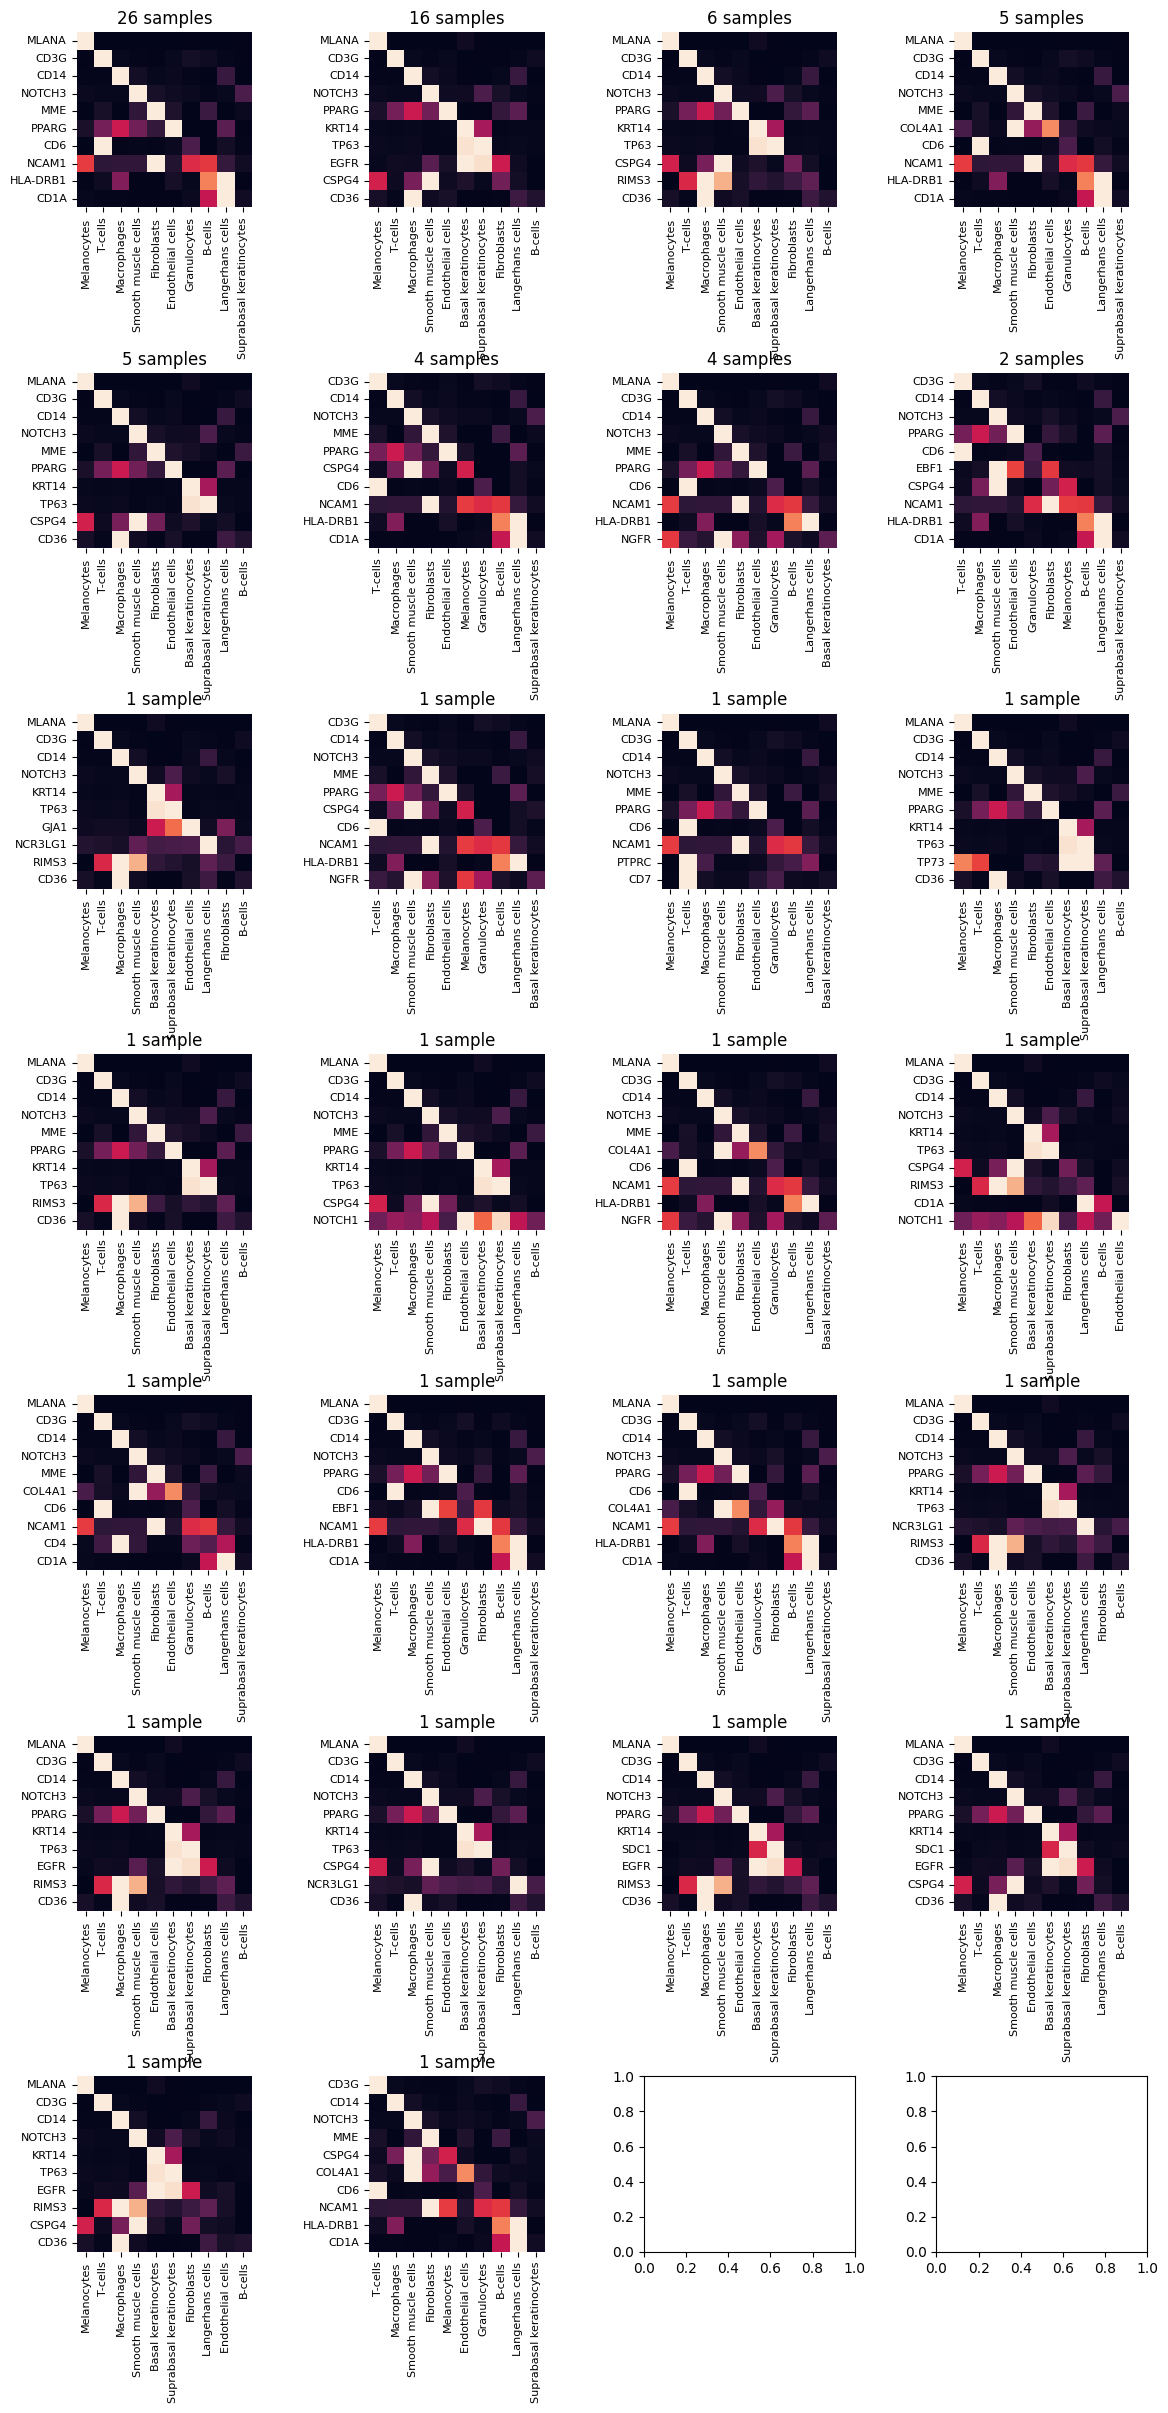

In [63]:
plt.style.use("default")
f, axs = plt.subplots(7, 4, figsize=(12, 24))
for i, row in enumerate(row_counts.index.values):
    hm, cell_types = assignment_heatmap(reference, row)
    hm = hm.T
    if int(row_counts[i]) == 1:
        axs[i // 4, i % 4].set_title(f"{int(row_counts[i])} sample")
    else:
        axs[i // 4, i % 4].set_title(f"{int(row_counts[i])} samples")
    sns.heatmap(hm, ax=axs[i // 4, i % 4], square=True, cbar=False)
    axs[i // 4, i % 4].tick_params(axis='x', labelsize=8)  # Change the fontsize as needed
    axs[i // 4, i % 4].tick_params(axis='y', labelsize=8)
    axs[i // 4, i % 4].set_xticks(np.array(range(len(cell_types))) + 0.5)
    axs[i // 4, i % 4].set_xticklabels(cell_types)

plt.tight_layout()
#plt.savefig("../../result_plots/heatmap.pdf", bbox_inches="tight")